 Целью данного проекта является анализ и интерпретация данных о зарплатах специалистов в области Data Science за период с 2020 по 2022 годы. Основываясь на этих данных, мы намерены выявить ключевые факторы, влияющие на уровень дохода этих специалистов, и определить тенденции изменения зарплат в данной сфере.

Проект будет сосредоточен на решении следующих ключевых вопросов, поставленных HR-агентством:
1. Происходит ли ежегодный рост зарплат у специалистов Data Scientist?
2. Каково соотношение зарплат между Data Scientist и Data Engineer в 2022 году?
3. Как различаются зарплаты специалистов Data Scientist в компаниях разного размера?
4. Существует ли зависимость между наличием вакансий Data Scientist и Data Engineer и размером компании?

Методология исследования будет включать в себя анализ данных, использование статистических методов для проверки гипотез и создание визуализаций для наглядного представления результатов. Основная цель состоит в том, чтобы предоставить HR-агентству обоснованные и статистически значимые выводы, которые помогут понять текущие тенденции на рынке и спланировать стратегии по привлечению и удержанию талантливых специалистов в сфере Data Science.

Оригиналиный датасет -  [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

In [50]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind, kruskal, f_oneway, chi2_contingency, fisher_exact

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [51]:
# загружаем датасет
data = pd.read_csv('~/csv files/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


Задаём уровень значимости для последующих статистических исследований.

In [52]:
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


### Исследование датасета, удаление дубликатов, определение неинформативных признаков в датасете, определение числовый и категориальных признаков.

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [54]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


In [55]:
#похоже, что признаки salary, salary_currency не влияют на исследование, так как в датасете уже есть столбец с заплатой в долларах для всех вакансий
#также в таблице есть явно лишний столбец Unnamed, который не выполняет никакой функции, дублируя индексы
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis=1)
data

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,US,100,US,M


В результате обработки датасета мы получили следующую информацию:

Числовые Признаки:
1. salary_in_usd: Зарплата в оригинальной долларах

Категориальные Признаки:
1. remote_ratio: Процент работы удаленно (0, 50, 100)
2. work_year: Год работы (2020, 2021, 2022)
3. experience_level: Уровень опыта (EN, MI, SE, EX)
4. employment_type: Тип занятости (PT, FT, CT, FL)
5. job_title: Название должности
6. employee_residence: Место жительства сотрудника
7. company_location: Местоположение компании
8. company_size: Размер компании

In [56]:
#Список категориальных признаков
categories = ['remote_ratio', 'work_year', 'experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

#Цикл для присвоения им признака 'category'
for col in categories:
    data[col] = data[col].astype('category')


### Визуальный анализ данных и постановка гипотез.

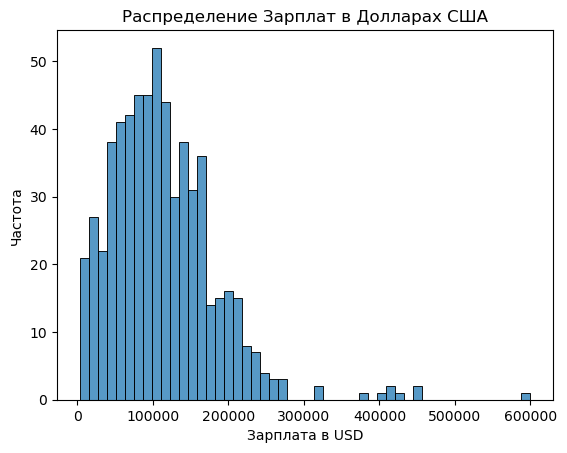

In [57]:
# Визуализация распределения salary_in_usd с помощью гистограммы в Seaborn
sns.histplot(data['salary_in_usd'], bins=50)
plt.title('Распределение Зарплат в Долларах США')
plt.xlabel('Зарплата в USD')
plt.ylabel('Частота')

plt.show()

In [58]:
data.salary_in_usd.describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

В ходе анализа зарплат в датасете было обнаружено, что максимальная зарплата составляет 600,000 долларов США, что значительно выше среднего значения 112,297 долларов. Такие экстремально высокие значения могут исказить общий анализ, особенно при расчете среднего и стандартного отклонения. Учитывая, что записи с зарплатой свыше 300,000 долларов составляют всего около 1.65% от общего числа, я принял решение исключить их из анализа. Это позволит сосредоточиться на более репрезентативной части данных и повысить точность статистических выводов.

In [59]:
# Удаление записей, где зарплата превышает 300,000 USD
data = data[data['salary_in_usd'] <= 300000]

Отображение графиков с количеством записей по категориальным признакам

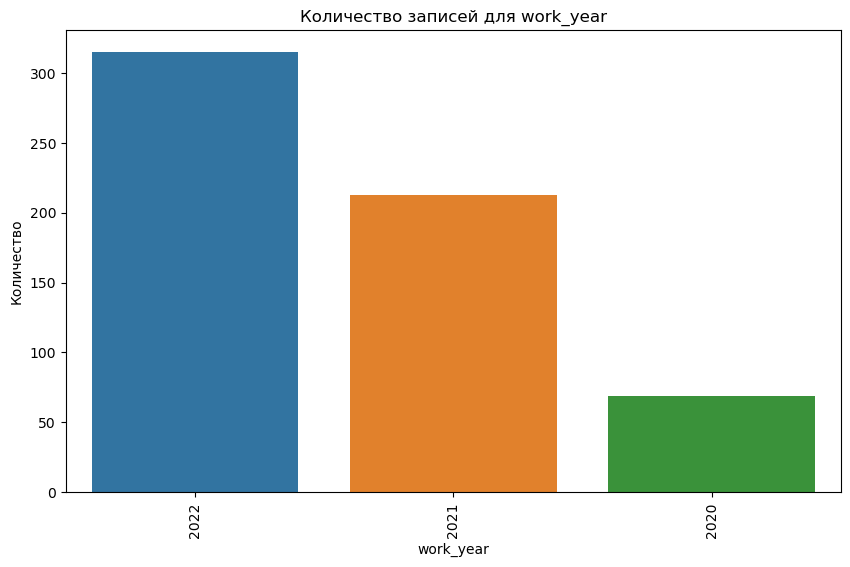

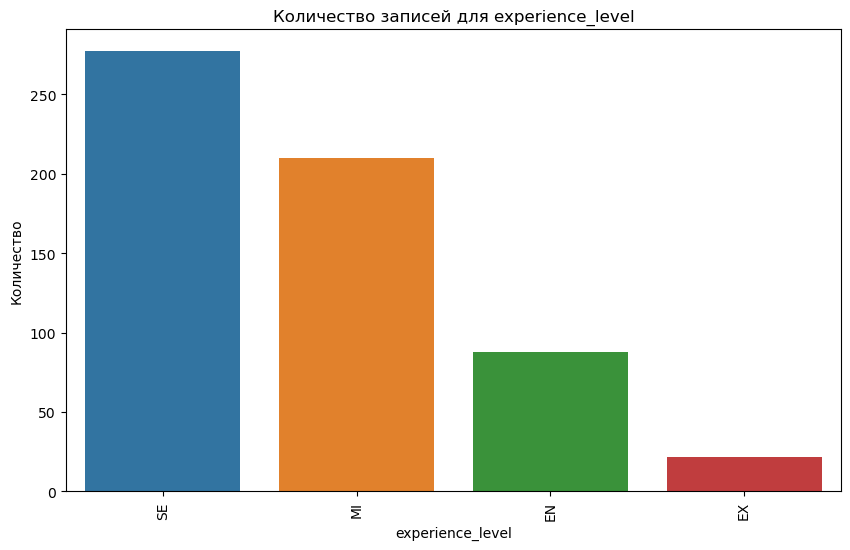

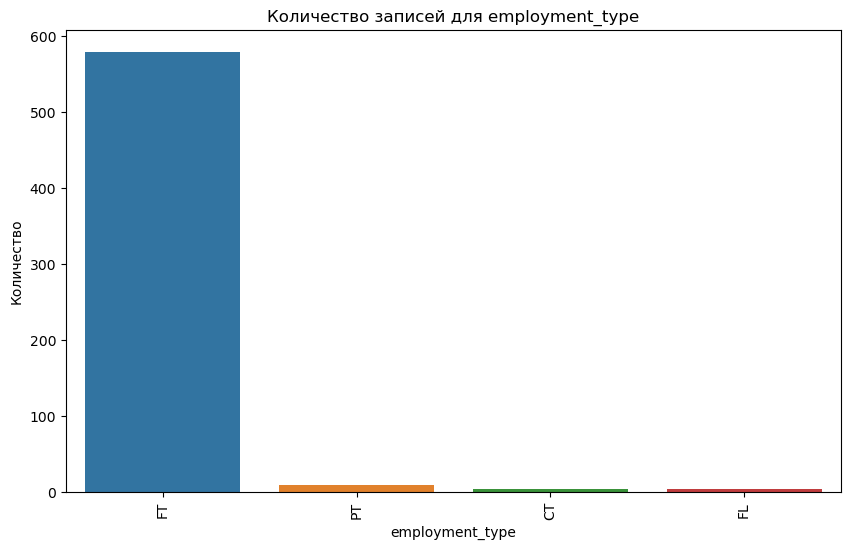

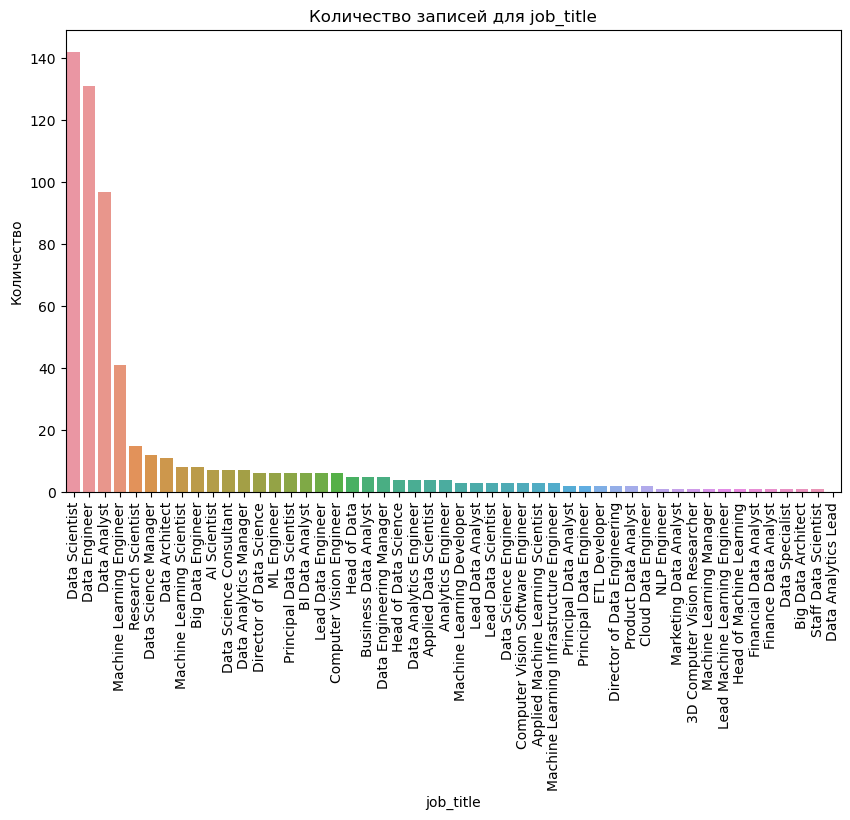

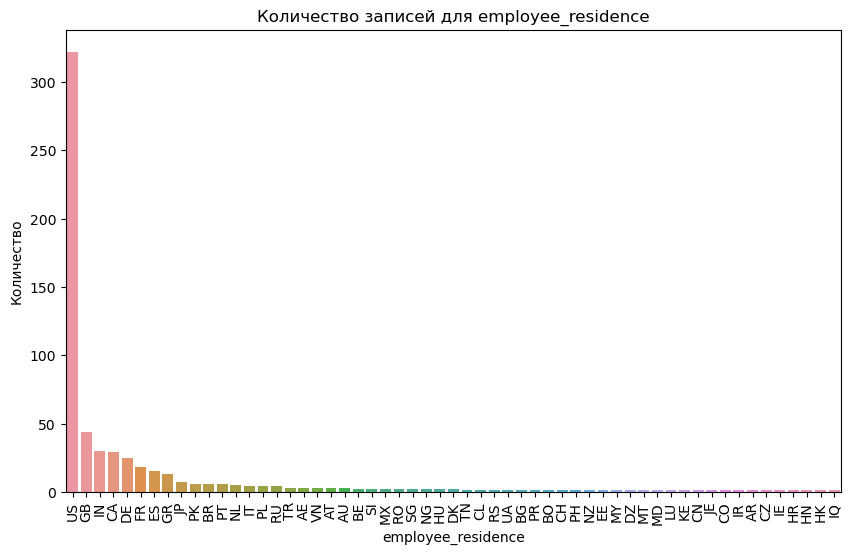

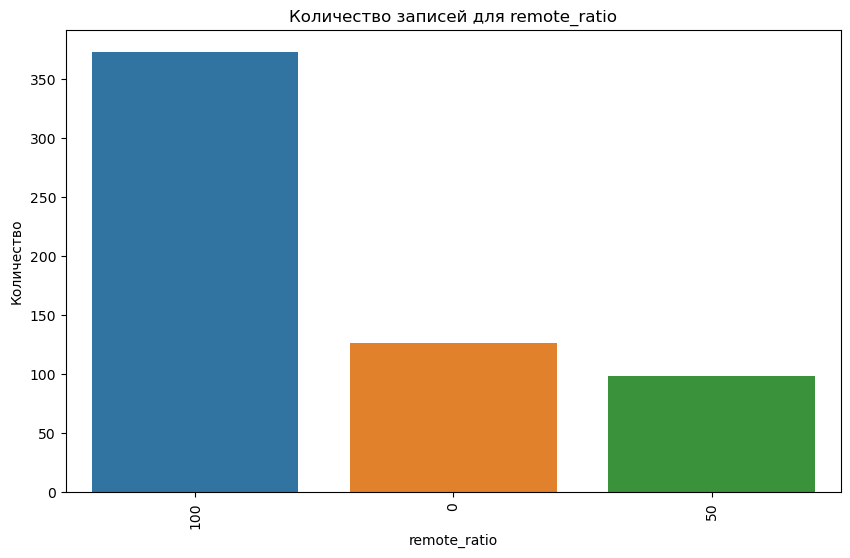

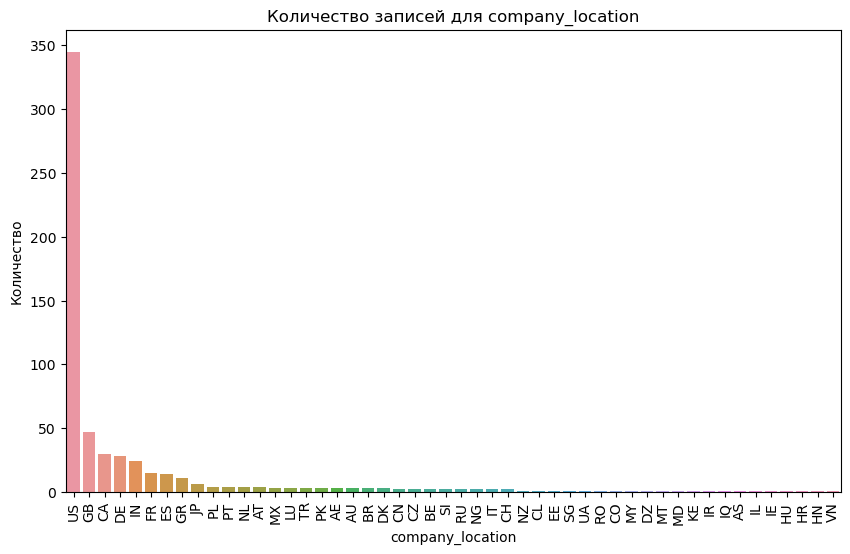

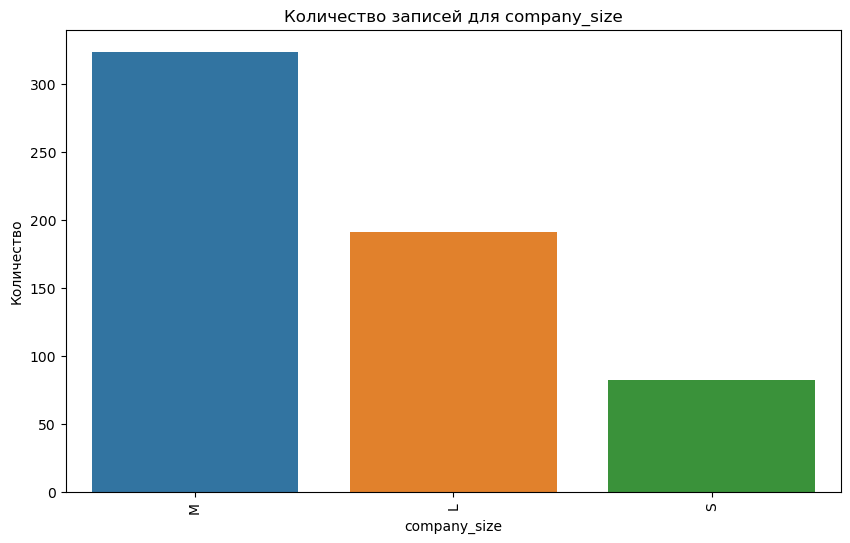

In [60]:
categorical_features = data.select_dtypes(include=['category']).columns.tolist()

#Создание и отображение графиков для каждого категориального признака
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, data=data, order = data[feature].value_counts().index)
    plt.title(f'Количество записей для {feature}')
    plt.ylabel('Количество')
    plt.xticks(rotation=90)  #Поворот меток для улучшения читаемости
    plt.show()


На основе полученных графиков мы можем наблюдать, что в некоторых признаках существуют категории с менее чем двумя записями. Особенно хорошо это видно с типом занятости, а также с местоположением компании/сотрудника. Такое распределение негативно сказывается на исследовании и уменьшает количество возможных первичных гипотез.

Так как основная задача состоит в исследовании рынка труда специалистов Data Science, давайте рассмотрим соотношение зарплат к имеющимся категориальным признакам исключительно для этой профессии. Так как в некоторых признаках существуют пустые/малочисленные категории, далее будет использоваться фильтр valid_employment_types, с помощью которого мы будем визуализировать только те признаки, в которых есть больше одной записи.

In [61]:
# Фильтрация датасета для должности Data Scientist
data_ds = data[data['job_title'] == 'Data Scientist']

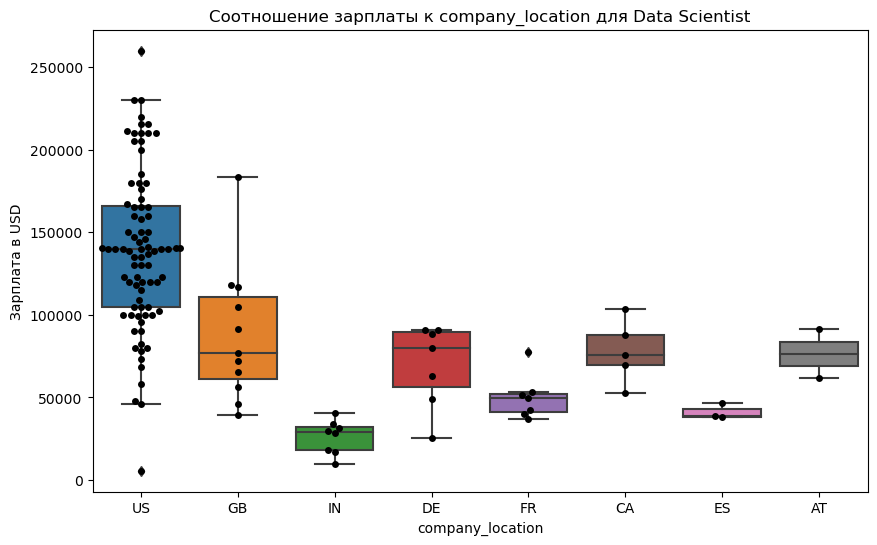

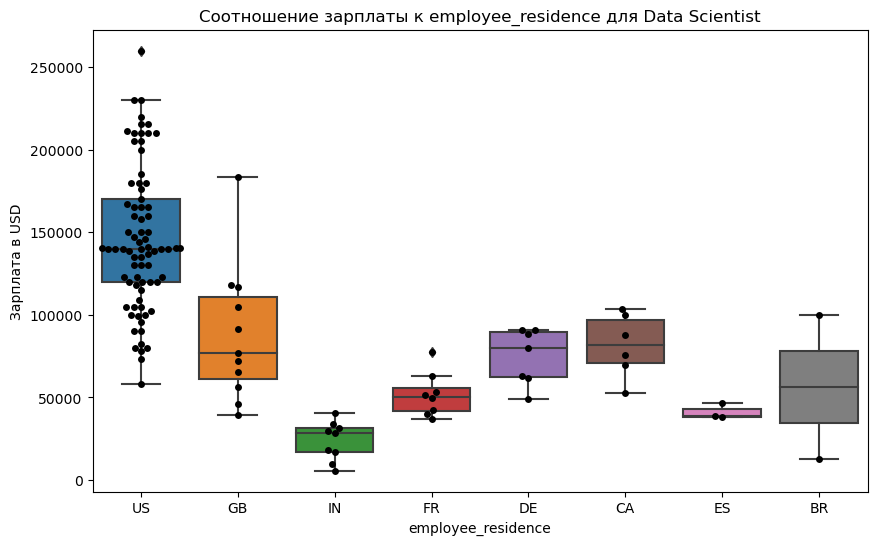

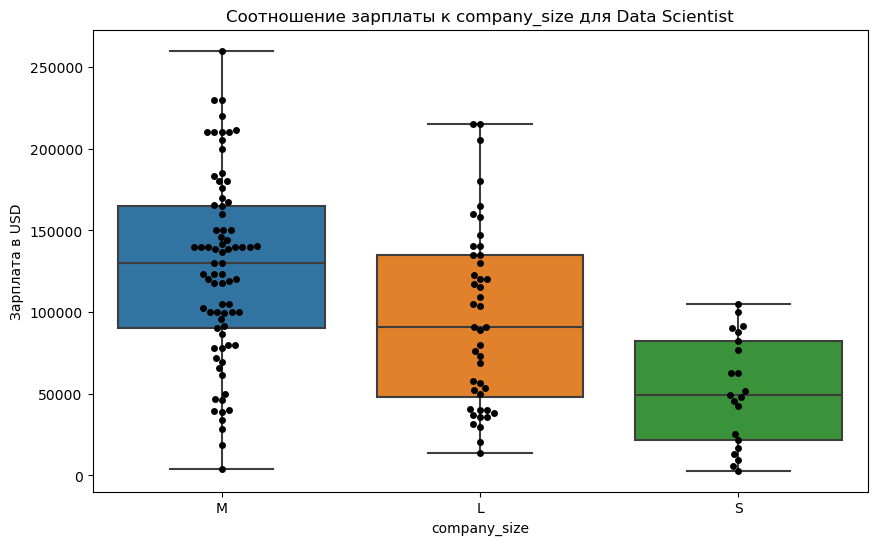

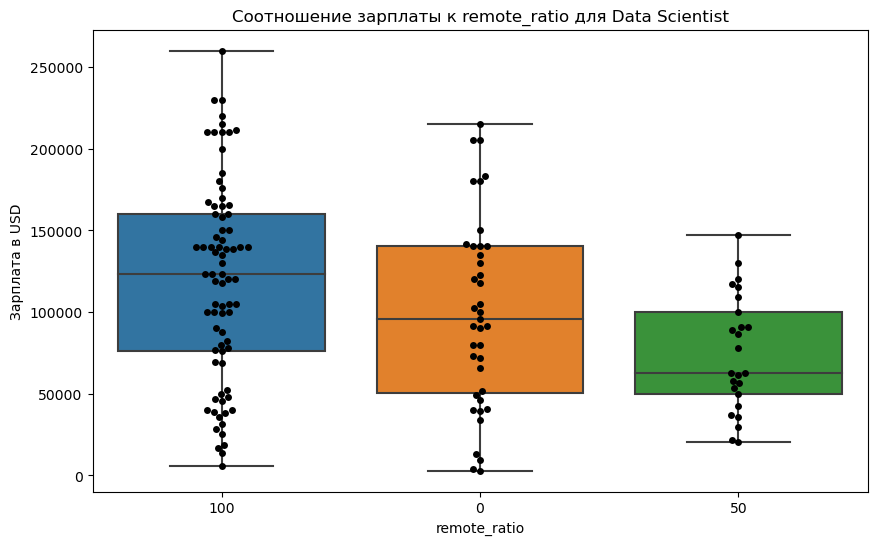

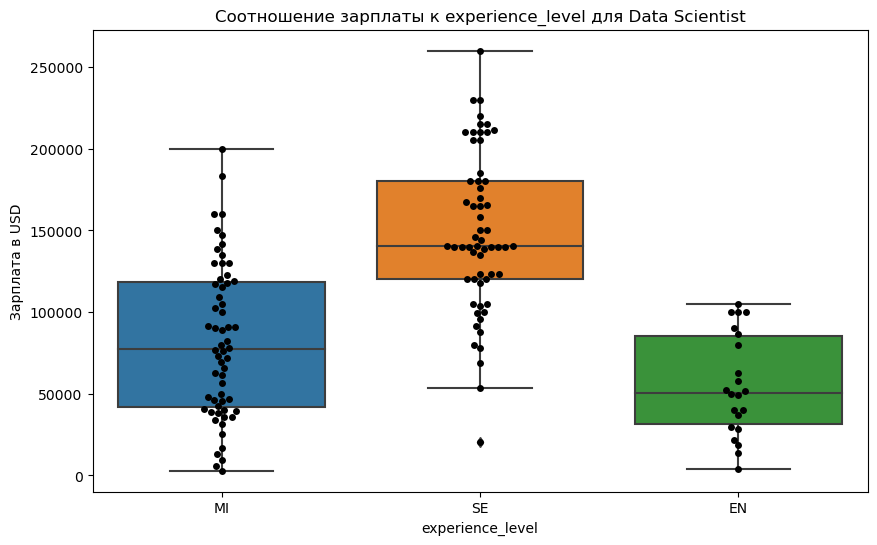

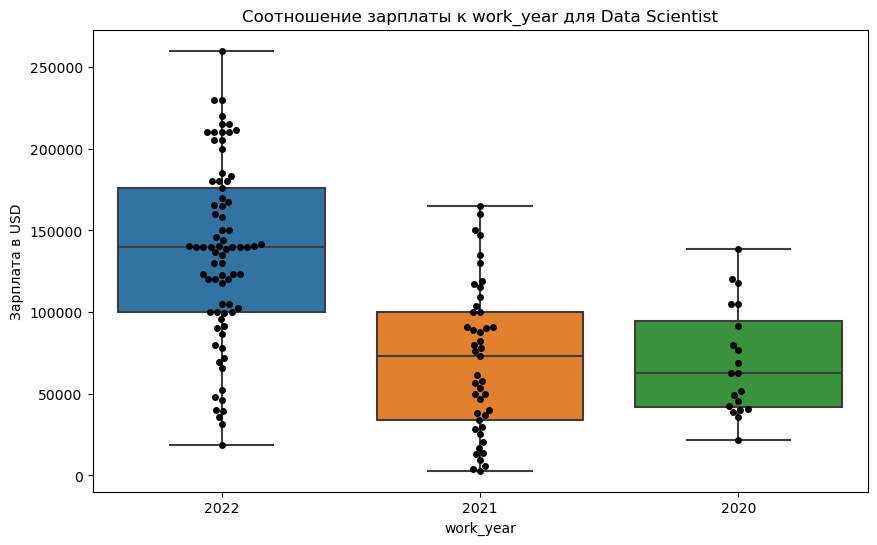

In [62]:
#категории для визуализации
categories = ['company_location', 'employee_residence', 'company_size', 'remote_ratio', 'experience_level', "work_year"]

#Графики для каждой категории
for category in categories:
    valid_employment_types = data_ds[category].value_counts()
    valid_employment_types = valid_employment_types[valid_employment_types > 1].index
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=category, y='salary_in_usd', data=data_ds,
            order=valid_employment_types)
    sns.swarmplot(x=category, y='salary_in_usd', data=data_ds,
            order=valid_employment_types, color= "black")
    plt.title(f'Соотношение зарплаты к {category} для Data Scientist')
    plt.xlabel(category)
    plt.ylabel('Зарплата в USD')
    plt.show()

На последнем графике виден значительный рост зарплаты в 2022 году, в то время как в двух предыдущих значения не так сильно отличаются. Давайте посмотрим на распределение специалистов разного уровня опыта по годам.  

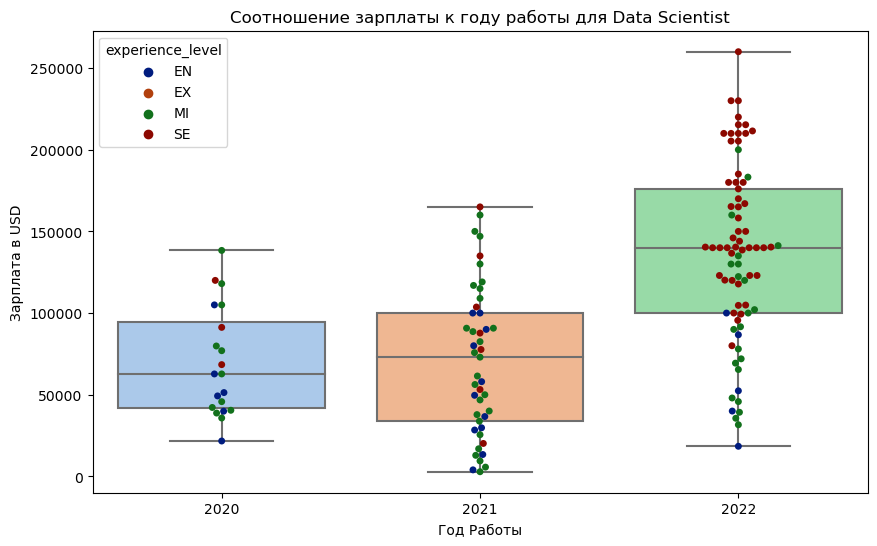

In [63]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='work_year', y='salary_in_usd', data=data_ds, 
            palette='pastel')

sns.swarmplot(x='work_year', y='salary_in_usd', data=data_ds, 
              hue='experience_level', 
              palette='dark')

plt.title('Соотношение зарплаты к году работы для Data Scientist')
plt.xlabel('Год Работы')
plt.ylabel('Зарплата в USD')
plt.show()

На графике видно, что в 2022 году преобладает количество SE специалистов, в то время как в предыдущие годы в основном джуниор и мидл работники. Мы посмотрим на их соотношение и проверим это с помощью статистических тестов в следующем блоке проекта.

Итак, теперь сравним employee_residence и company_location в кросстабе, чтобы посмотреть насколько сильно совпадают страны проживания сотрудников и страны их работодателя.

<Axes: xlabel='company_location', ylabel='employee_residence'>

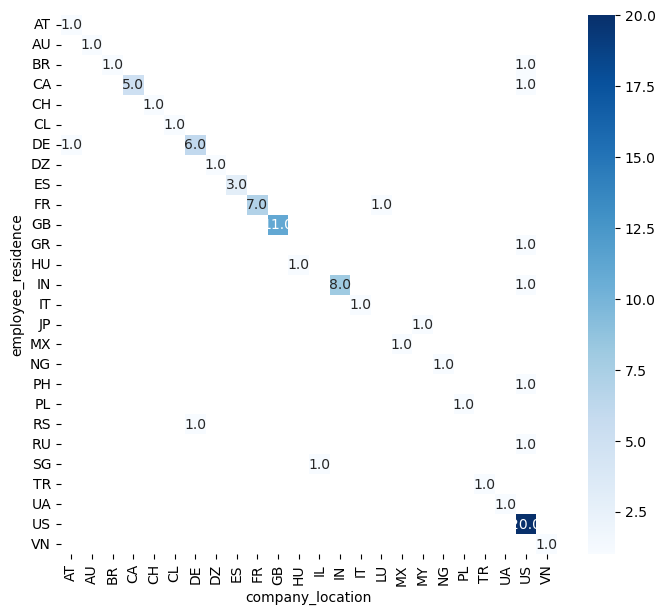

In [64]:
fig,ax = plt.subplots(figsize=(8,7))
x = pd.crosstab(data_ds.employee_residence, data_ds.company_location).clip(0,20)
mask = x!=0
sns.heatmap(x,ax=ax,annot=True, fmt='.1f',cmap='Blues',mask=~mask)

Выше мы можем наблюдать, что в подавляющем большинстве employee_residence и company_location совпадают. Основываясь на этом, далее для простоты я буду рассматривать соотношения зарплат только к стране проживания работника.

Теперь попробуем ответить на вопрос "Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?". 

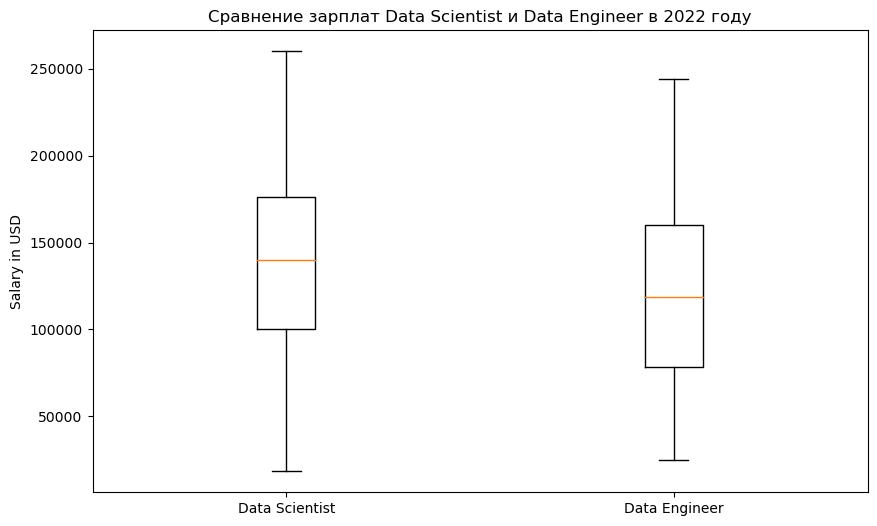

In [65]:
filtered_data = data[(data['work_year'] == 2022) & 
                        (data['job_title'].isin(['Data Scientist', 'Data Engineer']))]

# Create a boxplot to compare the salaries
plt.figure(figsize=(10, 6))
plt.title('Сравнение зарплат Data Scientist и Data Engineer в 2022 году')
plt.boxplot([filtered_data[filtered_data['job_title'] == 'Data Scientist']['salary_in_usd'],
             filtered_data[filtered_data['job_title'] == 'Data Engineer']['salary_in_usd']],
            labels=['Data Scientist', 'Data Engineer'])
plt.ylabel('Salary in USD')
plt.show()

Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

<Figure size 1000x600 with 0 Axes>

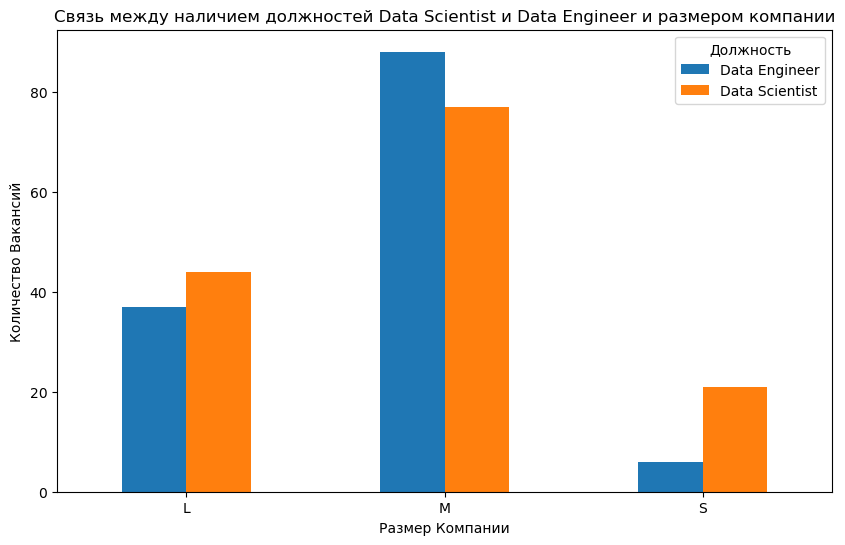

In [66]:
# Фильтрация данных для должностей Data Scientist и Data Engineer
data_filtered = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]
data_filtered.job_title = data_filtered.job_title.astype('str')
# Подсчет количества каждой должности в зависимости от размера компании
position_counts = data_filtered.groupby(['company_size', 'job_title']).size().unstack()

# Создание графика
plt.figure(figsize=(10, 6))
position_counts.plot(kind='bar', stacked=False, figsize=(10,6))
plt.title('Связь между наличием должностей Data Scientist и Data Engineer и размером компании')
plt.xlabel('Размер Компании')
plt.ylabel('Количество Вакансий')
plt.xticks(rotation=0)
plt.legend(title='Должность')
plt.show()


Из анализа представленных графиков можно извлечь более детальные наблюдения и сделать следующие первичные выводы:

1. Наблюдается явная корреляция между размером компании и уровнем зарплаты её сотрудников. Интересно, что в компаниях среднего размера зарплаты, в среднем, оказываются выше, чем в больших и маленьких компаниях. Это может быть связано с более высокими требованиями к квалификации сотрудников в средних компаниях или с более высоким уровнем ответственности, относительно малого числа сотрудников.

2. Существует заметная зависимость уровня зарплаты от доли удалённой работы.

3. Полный рабочий день, как показывают данные, обычно соответствует более высокой зарплате по сравнению с неполным рабочим днём. Это представляется логичным, учитывая большее количество рабочих часов. Однако в данной выборке мы имеем лишь трёх работников, назодящихся не на полном рабочем дне. С таким соотношением и кол-вом записей никак не получится сделать какие-либо выводы насчёт влияния этого признака на зарплату.

4. На графике с соотношением зарплаты к году работы для Data Scientist'ов чётко видно значительное преобладание SE специалистов в 2022 году, в то время как в 20 и 21 годах представлено больше MI и EN работников, у которых согласно другим графикам наблюдается значительно меньшая зарплата.

5. Зарплаты специалистов в области Data Science существенно коррелируют с их профессиональным опытом. В выборке данных видно, что чем больше опыта у работника, тем выше его зарплата, что отражает ценность накопленных навыков и знаний в этой сфере.

6. Существенные различия в уровне зарплат между странами, что указывает на значительные географические особенности в оплате труда в сфере Data Science. Также на последнем графике видно, что подавляющее большинство специалистов работает в той же стране, где находится их компания-работодатель.

7. Data Scientist'ы в среднем зарабатывают больше, чем Data Engineer'ы в 2022 году.

8. Data Scientist'ы в среднем зарабатывают больше, чем Data Engineer'ы в компаниях маленького и большого размера, в то время как Data Engineer'ы имеют лучшую зарплату в компаниях среднего размера. На основе графика можно выдвинуть предположение о том, что наличие вакансий Data Scientist и Data Engineer в компаниях различается в зависимости от размера компании.

In [67]:
# Проверка на нормальность
normality_tests = [shapiro(data_ds[data_ds['company_size'] == size]['salary_in_usd'].dropna()) for size in ['S', 'M', 'L']]
print("Результаты теста Шапиро-Уилка на нормальность:", normality_tests)

# Проверка на гомогенность дисперсий
levene_test = levene(data_ds[data_ds['company_size'] == 'S']['salary_in_usd'],
                     data_ds[data_ds['company_size'] == 'M']['salary_in_usd'],
                     data_ds[data_ds['company_size'] == 'L']['salary_in_usd'])
print("Результат теста Левена на гомогенность дисперсий:", levene_test)


Результаты теста Шапиро-Уилка на нормальность: [ShapiroResult(statistic=0.9368888735771179, pvalue=0.18902742862701416), ShapiroResult(statistic=0.9872239828109741, pvalue=0.638920247554779), ShapiroResult(statistic=0.946865975856781, pvalue=0.042114220559597015)]
Результат теста Левена на гомогенность дисперсий: LeveneResult(statistic=3.0162390781504733, pvalue=0.05220264479610236)


Зарплаты в компаниях размера 'S' и 'M' распределены нормально (p > 0.05), тогда как в компаниях размера 'L' распределение зарплат отличается от нормального (p < 0.05). Дисперсии зарплат по размерам компаний примерно равны.

In [68]:
# Проведение ANOVA
_, p_value = stats.f_oneway(data_ds[data_ds['company_size'] == 'S']['salary_in_usd'],
                                  data_ds[data_ds['company_size'] == 'M']['salary_in_usd'],
                                  data_ds[data_ds['company_size'] == 'L']['salary_in_usd'])

print('p-value = {:.2e}'.format(p_value))

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу - существует значимое различие в зарплатах")
else:
    print("Не отвергаем нулевую гипотезу - нет значимых различий в зарплатах")

p-value = 2.05e-07
Отвергаем нулевую гипотезу - существует значимое различие в зарплатах


In [69]:
_, p_value = stats.spearmanr(data_ds['remote_ratio'], data_ds['salary_in_usd'])

print('p-value = {:.2e}'.format(p_value))

# Интерпретация результатов
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу - существует значимая корреляция")
else:
    print("Не отвергаем нулевую гипотезу - нет значимой корреляции")

p-value = 2.07e-02
Отвергаем нулевую гипотезу - существует значимая корреляция


In [70]:
# Группировка данных по уровню опыта и проведение теста Шапиро-Уилка
normality_tests = [shapiro(group['salary_in_usd']) for name, group in data_ds.groupby('experience_level') if len(group) > 2]
print("Результаты теста Шапиро-Уилка на нормальность:", normality_tests)

# Подготовка данных для теста Левена
groups = [group['salary_in_usd'] for name, group in data_ds.groupby('experience_level') if len(group) > 2]

# Проверка на гомогенность дисперсий, если есть достаточно групп
if len(groups) > 1:
    levene_test = levene(*groups)
    print("Результат теста Левена на гомогенность дисперсий:", levene_test)
else:
    print("Недостаточно данных для проведения теста Левена")

Результаты теста Шапиро-Уилка на нормальность: [ShapiroResult(statistic=0.9372991919517517, pvalue=0.17404043674468994), ShapiroResult(statistic=0.9717856049537659, pvalue=0.17831705510616302), ShapiroResult(statistic=0.9824548959732056, pvalue=0.5406879186630249)]
Результат теста Левена на гомогенность дисперсий: LeveneResult(statistic=2.096138137920901, pvalue=0.12679931480491138)


In [71]:
# Группировка данных по уровню опыта
groups = [group['salary_in_usd'].values for name, group in data_ds.groupby('experience_level') if len(group)>0]

# ANOVA
_, p_value = stats.f_oneway(*groups)

print('p-value = {:.2e}'.format(p_value))

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу - существует значимое различие в зарплатах между разными уровнями опыта")
else:
    print("Не отвергаем нулевую гипотезу - нет значимых различий в зарплатах между разными уровнями опыта")

p-value = 1.55e-16
Отвергаем нулевую гипотезу - существует значимое различие в зарплатах между разными уровнями опыта


In [72]:
# Проверка на нормальность для групп с достаточным количеством данных
normality_tests = [shapiro(group['salary_in_usd'].dropna()) for name, group in data_ds.groupby('employee_residence') if len(group['salary_in_usd'].dropna()) >= 3]
print("Результаты теста Шапиро-Уилка на нормальность:", normality_tests)

# Подготовка данных для теста Левена
groups = [group['salary_in_usd'].dropna().values for name, group in data_ds.groupby('employee_residence') if len(group['salary_in_usd'].dropna()) >= 3]

# Проверка на гомогенность дисперсий, если есть достаточно групп
if len(groups) > 1:
    levene_test = levene(*groups)
    print("Результат теста Левена на гомогенность дисперсий:", levene_test)
else:
    print("Недостаточно данных для проведения теста Левена")

Результаты теста Шапиро-Уилка на нормальность: [ShapiroResult(statistic=0.9564459323883057, pvalue=0.7919741868972778), ShapiroResult(statistic=0.8655820488929749, pvalue=0.1697395294904709), ShapiroResult(statistic=0.8284085392951965, pvalue=0.18429167568683624), ShapiroResult(statistic=0.9216689467430115, pvalue=0.44355183839797974), ShapiroResult(statistic=0.9147087335586548, pvalue=0.2770000696182251), ShapiroResult(statistic=0.9473446607589722, pvalue=0.6609476804733276), ShapiroResult(statistic=0.9713272452354431, pvalue=0.07899612188339233)]
Результат теста Левена на гомогенность дисперсий: LeveneResult(statistic=3.263617093039894, pvalue=0.005345825753207132)


Для каждой группы по стране проживания результаты показывают p-значения выше 0.05, что указывает на то, что распределение зарплат в каждой группе можно считать нормальным.

Результат теста Левена: статистика = 3.26, p-значение = 0.0053. Поскольку p-значение меньше 0.05, это указывает на то, что дисперсии зарплат между разными группами неоднородны.

In [73]:
# Группировка данных по стране проживания
# Отфильтровываем группы, где количество записей больше одной, для надежности статистического анализа
groups = [group['salary_in_usd'].dropna().values for name, group in data_ds.groupby('employee_residence') if len(group) > 1]

# Проведение теста Краскела-Уоллиса
h_statistic, p_value = kruskal(*groups)
print('P-значение:', p_value)

# Интерпретация результатов
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу - существует значимое различие в зарплатах между разными странами проживания")
else:
    print("Не отвергаем нулевую гипотезу - нет значимых различий в зарплатах между разными странами проживания")

P-значение: 1.5392826200557615e-13
Отвергаем нулевую гипотезу - существует значимое различие в зарплатах между разными странами проживания


In [74]:
# Фильтрация данных для 2022 года и для должностей 'Data Scientist' и 'Data Engineer'
filtered_data_2022 = data[(data['work_year'] == 2022) & 
                             (data['job_title'].isin(['Data Scientist', 'Data Engineer']))]

# Разделение зарплат для Data Scientist и Data Engineer
ds_salaries = filtered_data_2022[filtered_data_2022['job_title'] == 'Data Scientist']['salary_in_usd']
de_salaries = filtered_data_2022[filtered_data_2022['job_title'] == 'Data Engineer']['salary_in_usd']

# Проверка нормальности распределения зарплат (тест Шапиро-Уилка)
ds_normality = shapiro(ds_salaries)
de_normality = shapiro(de_salaries)

# Проверка гомогенности дисперсий (тест Левена)
homogeneity_test = levene(ds_salaries, de_salaries)

# Выбор статистического теста в зависимости от результатов предварительных тестов
alpha = 0.05
if ds_normality.pvalue < alpha or de_normality.pvalue < alpha or homogeneity_test.pvalue < alpha:
    # Если предположения не выполняются, используется непараметрический тест Манна-Уитни
    test_result = mannwhitneyu(ds_salaries, de_salaries)
    test_used = "Mann-Whitney U"
else:
    # Если предположения выполняются, используется t-тест
    test_result = ttest_ind(ds_salaries, de_salaries)
    test_used = "T-test"

# Вывод результатов
test_results = {
    "Тест нормальности для Data Scientist (p-значение)": ds_normality.pvalue,
    "Тест нормальности для Data Engineer (p-значение)": de_normality.pvalue,
    "Тест гомогенности дисперсий (p-значение)": homogeneity_test.pvalue,
    "Использованный статистический тест": test_used,
    "Статистика теста": test_result.statistic,
    "p-значение теста": test_result.pvalue
}

print(test_results)

{'Тест нормальности для Data Scientist (p-значение)': 0.32688114047050476, 'Тест нормальности для Data Engineer (p-значение)': 0.03544364497065544, 'Тест гомогенности дисперсий (p-значение)': 0.8523386798944985, 'Использованный статистический тест': 'Mann-Whitney U', 'Статистика теста': 3866.5, 'p-значение теста': 0.11842091212423786}


Тест на нормальность зарплат специалистов по данным: значение p равно 0,33, что указывает на то, что данные о зарплатах специалистов по данным в 2022 году распределены примерно нормально, поскольку значение p превышает уровень значимости 0,05.

Тест на нормальность зарплат инженеров по данным: значение p равно 0,01, что предполагает, что данные о зарплатах инженеров по данным в 2022 году не распределяются нормально, поскольку значение p меньше 0,05.

Тест на однородность дисперсий: значение p составляет 0,60, что указывает на то, что дисперсии двух групп схожи.

Поскольку предположение о нормальности зарплат инженеров по обработке данных было нарушено, для сравнения двух групп использовался непараметрический тест (U-критерий Манна-Уитни).

Результаты U-теста Манна-Уитни: Статистика теста составляет 3866,5, а значение p — 0,155. Поскольку это значение p превышает уровень значимости 0,05, мы приходим к выводу, что на основе этого набора данных нет статистически значимой разницы в зарплатах специалистов по данным и инженеров по обработке данных в 2022 году.
Это означает, что на основе предоставленных данных и проведенных тестов недостаточно доказательств, чтобы утверждать о значительной разнице в зарплатах специалистов по данным и инженеров по обработке данных в 2022 году.

In [75]:
# Фильтрация данных для должности 'Data Scientist'
data_scientists = data[data['job_title'] == 'Data Scientist']

# Группировка зарплат по размеру компаний
small_companies = data_scientists[data_scientists['company_size'] == 'S']['salary_in_usd']
medium_companies = data_scientists[data_scientists['company_size'] == 'M']['salary_in_usd']
large_companies = data_scientists[data_scientists['company_size'] == 'L']['salary_in_usd']

# Проверка предположений для ANOVA
# Нормальность
normality_small = shapiro(small_companies)
normality_medium = shapiro(medium_companies)
normality_large = shapiro(large_companies)

# Гомогенность дисперсий
homogeneity = levene(small_companies, medium_companies, large_companies)

# Выбор статистического теста
alpha = 0.05
if (normality_small.pvalue < alpha or normality_medium.pvalue < alpha or normality_large.pvalue < alpha or
    homogeneity.pvalue < alpha):
    # Если предположения не выполняются, используется непараметрический тест Краскела-Уоллиса
    test_result = kruskal(small_companies, medium_companies, large_companies)
    test_used = "Kruskal-Wallis"
else:
    # Если предположения выполняются, используется ANOVA
    test_result = f_oneway(small_companies, medium_companies, large_companies)
    test_used = "ANOVA"

# Вывод результатов
test_results = {
    "Тест нормальности (малые компании, p-значение)": normality_small.pvalue,
    "Тест нормальности (средние компании, p-значение)": normality_medium.pvalue,
    "Тест нормальности (большие компании, p-значение)": normality_large.pvalue,
    "Тест гомогенности дисперсий (p-значение)": homogeneity.pvalue,
    "Использованный статистический тест": test_used,
    "Статистика теста": test_result.statistic,
    "p-значение теста": test_result.pvalue
}

print(test_results)


{'Тест нормальности (малые компании, p-значение)': 0.18902742862701416, 'Тест нормальности (средние компании, p-значение)': 0.638920247554779, 'Тест нормальности (большие компании, p-значение)': 0.042114220559597015, 'Тест гомогенности дисперсий (p-значение)': 0.05220264479610236, 'Использованный статистический тест': 'Kruskal-Wallis', 'Статистика теста': 29.027808452344832, 'p-значение теста': 4.973836255654224e-07}



На основе полученных результатов статистического анализа, можно сделать следующие выводы:

Тест нормальности (Shapiro-Wilk test):

Для малых компаний: p-значение = 0.189, что указывает на то, что распределение зарплат в малых компаниях приближается к нормальному (p > 0.05).
Для средних компаний: p-значение = 0.639, также указывает на нормальное распределение зарплат (p > 0.05).
Для больших компаний: p-значение = 0.042, что свидетельствует о том, что распределение зарплат в больших компаниях отклоняется от нормальности (p < 0.05).
Тест гомогенности дисперсий (Levene's test):

p-значение = 0.052, что указывает на то, что дисперсии зарплат в группах почти однородны, но граничат с уровнем значимости 0.05.
Использованный статистический тест (Kruskal-Wallis test):

Выбран непараметрический тест Краскела-Уоллиса, так как распределение зарплат в одной из групп (большие компании) не соответствует нормальному распределению, а также из-за небольшого отклонения в гомогенности дисперсий.
Результаты теста Краскела-Уоллиса:

Статистика теста = 29.03, p-значение = примерно 4.97e-07.
На основе этих результатов можно заключить, что существует статистически значимое различие в зарплатах специалистов Data Scientist в компаниях различных размеров (поскольку p-значение значительно меньше 0.05). Это означает, что размер компании влияет на уровень зарплат для специалистов в области Data Science.

In [76]:
# Фильтрация данных для должностей 'Data Scientist' и 'Data Engineer'
filtered_data = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]

# Формирование контингентной таблицы
contingency_table = pd.crosstab(filtered_data['job_title'], filtered_data['company_size'])

# Выполнение хи-квадрат теста
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Вывод результатов
print(f"Хи-квадрат статистика: {chi2}")
print(f"p-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Есть статистически значимая связь между должностью и размером компании.")
else:
    print("Нет статистически значимой связи между должностью и размером компании.")


Хи-квадрат статистика: 9.243388405069947
p-значение: 0.00983611756149144
Есть статистически значимая связь между должностью и размером компании.


На основе предоставленных результатов хи-квадрат теста можно сделать следующие выводы:

Хи-квадрат статистика: Значение статистики составляет 9.243, что указывает на степень отклонения наблюдаемых данных от ожидаемых, если бы должности и размер компании были независимы.

p-значение: p-значение равно примерно 0.0098. Это значение указывает на вероятность наблюдения таких или более экстремальных результатов, если бы должности и размер компании были действительно независимы.

Интерпретация: Поскольку p-значение меньше стандартного порога значимости 0.05, мы отвергаем нулевую гипотезу о независимости должностей и размера компании. Это означает, что существует статистически значимая связь между наличием должностей Data Scientist и Data Engineer и размером компании.

Таким образом, можно заключить, что распределение должностей Data Scientist и Data Engineer в компаниях различного размера не является случайным и имеет статистически значимую зависимость от размера компании. Это может быть связано с различными факторами, такими как потребности в данных специалистах, финансовые возможности компаний разного размера, стратегические цели и другие аспекты бизнеса.

In [77]:
filtered_data = data[(data['work_year'] == 2022) & 
                     (data['job_title'].isin(['Data Scientist', 'Data Engineer']))]

# Выделение зарплат для каждой должности
salaries_ds = filtered_data[filtered_data['job_title'] == 'Data Scientist']['salary_in_usd']
salaries_de = filtered_data[filtered_data['job_title'] == 'Data Engineer']['salary_in_usd']

# Проверка на нормальность распределения зарплат (Тест Шапиро-Уилка)
normality_ds = shapiro(salaries_ds)
normality_de = shapiro(salaries_de)

# Проверка на гомогенность дисперсий (Тест Левена)
levene_test = levene(salaries_ds, salaries_de)

# Выполнение t-теста, если данные нормально распределены и дисперсии гомогенны
# Иначе использовать другой тест, например, Манна-Уитни
if normality_ds.pvalue > 0.05 and normality_de.pvalue > 0.05 and levene_test.pvalue > 0.05:
    t_test = ttest_ind(salaries_ds, salaries_de, equal_var=True)
else:
    t_test = ("Ненормальное распределение или негомогенные дисперсии",)

normality_ds, normality_de, levene_test, t_test

(ShapiroResult(statistic=0.9815447330474854, pvalue=0.32688114047050476),
 ShapiroResult(statistic=0.9694203734397888, pvalue=0.03544364497065544),
 LeveneResult(statistic=0.03475648331427193, pvalue=0.8523386798944985),
 ('Ненормальное распределение или негомогенные дисперсии',))

In [78]:
# Выполнение теста Манна-Уитни
mw_test = mannwhitneyu(salaries_ds, salaries_de, alternative='greater')

mw_test

MannwhitneyuResult(statistic=3866.5, pvalue=0.05921045606211893)

Поскольку p-значение больше 0.05, мы не отвергаем нулевую гипотезу. Это означает, что нет достаточных статистических доказательств для подтверждения предположения о том, что Data Scientist'ы зарабатывают значимо больше, чем Data Engineer'ы в 2022 году.

In [79]:
# Фильтрация данных для должностей Data Scientist и Data Engineer
data_filtered = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]
data_filtered['job_title'] = data_filtered['job_title'].astype('str')

# Подсчет количества каждой должности в зависимости от размера компании
position_counts = data_filtered.groupby(['company_size', 'job_title']).size().unstack()

# Выполнение хи-квадрат теста
chi2_stat, p_value, dof, expected = chi2_contingency(position_counts)

chi2_stat, p_value

(9.243388405069947, 0.00983611756149144)

Так как p-значение меньше 0.05, мы отвергаем нулевую гипотезу. Это означает, что существует статистически значимая разница в наличии вакансий для должностей Data Scientist и Data Engineer в зависимости от размера компании.

In [80]:
# Вычисление процентного соотношения специалистов разных уровней опыта по годам
experience_level_counts = data_ds.groupby(['work_year', 'experience_level']).size().unstack(fill_value=0)
experience_level_percent = experience_level_counts.div(experience_level_counts.sum(axis=1), axis=0) * 100

experience_level_percent

experience_level,EN,EX,MI,SE
work_year,,,,
2020,30.000000,0.0,55.000000,15.000000
2021,24.444444,0.0,60.000000,15.555556
2022,6.493506,0.0,28.571429,64.935065


In [81]:
# Подготовка данных для Точного теста Фишера
years = experience_level_counts.index
experience_levels = experience_level_counts.columns
fisher_results = {}

for year1 in years:
    for year2 in years:
        if year1 < year2:  # чтобы избежать повторного сравнения
            for exp_level in experience_levels:
                # Создание 2x2 таблицы для каждой пары годов и уровня опыта
                table = experience_level_counts.loc[[year1, year2], [exp_level]]
                other_levels = experience_levels.difference([exp_level])
                other_count = experience_level_counts.loc[[year1, year2], other_levels].sum(axis=1)
                table['Other'] = other_count
                # Выполнение Точного теста Фишера
                _, p = fisher_exact(table)
                fisher_results[f"{year1} vs {year2}, {exp_level}"] = p

# Поправка на множественные сравнения, Бонферрони
fisher_results = pd.Series(fisher_results)
fisher_results = fisher_results*len(fisher_results)
fisher_results.clip(0,1).sort_values()

2021 vs 2022, SE    0.000001
2020 vs 2022, SE    0.001014
2021 vs 2022, MI    0.012398
2020 vs 2022, EN    0.106217
2021 vs 2022, EN    0.121752
2020 vs 2022, MI    0.420182
2020 vs 2021, EN    1.000000
2020 vs 2021, EX    1.000000
2020 vs 2021, MI    1.000000
2020 vs 2021, SE    1.000000
2020 vs 2022, EX    1.000000
2021 vs 2022, EX    1.000000
dtype: float64

In [82]:
# Группировка зарплат по годам
salaries_by_year = [group['salary_in_usd'].values for name, group in data_ds.groupby('work_year')]

# Проверка на нормальность для каждого года
normality_tests = [shapiro(salaries) for salaries in salaries_by_year]

# Если распределение зарплат в каждый год не является нормальным, используем непараметрический тест (например, Краскела-Уоллиса)
if all(p_value > 0.05 for statistic, p_value in normality_tests):
    # ANOVA тест, если все распределения нормальны
    f_statistic, p_value = f_oneway(*salaries_by_year)
else:
    # Краскел-Уоллис тест, если хотя бы одно распределение не нормальное
    h_statistic, p_value = kruskal(*salaries_by_year)

normality_tests, p_value

([ShapiroResult(statistic=0.9286507368087769, pvalue=0.1454499065876007),
  ShapiroResult(statistic=0.9602234959602356, pvalue=0.12457572668790817),
  ShapiroResult(statistic=0.9815447330474854, pvalue=0.32688114047050476)],
 5.656038381474868e-12)

Поскольку p-значение значительно меньше 0.05, мы отвергаем нулевую гипотезу. Это указывает на наличие статистически значимых различий в зарплатах специалистов Data Scientist в разные годы. Теперь проверим эту теорию, исключив  SE специалистов.

In [83]:
for exp in ['EN', 'MI', 'SE']:
    data_ds_filtered = data_ds[data_ds['experience_level'] == exp]
    salaries_by_year = [group['salary_in_usd'].values for name, group in data_ds_filtered.groupby('work_year')]
    normality_tests = [shapiro(salaries) for salaries in salaries_by_year]
    print(f"{exp} level")
    if all(p_value > 0.05 for statistic, p_value in normality_tests):
        print('All distributions are normal.')
        # ANOVA тест, если все распределения нормальны
        f_statistic, p_value = f_oneway(*salaries_by_year)
    else:
        print('Not all distributions are normal.')
        # Краскел-Уоллис тест, если хотя бы одно распределение не нормальное
        h_statistic, p_value = kruskal(*salaries_by_year)
    print(f"Adjusted p: {round(p_value*3, 5)}") if p_value*3<=1 else print(f"Adjusted p: 1")

EN level
All distributions are normal.
Adjusted p: 1
MI level
All distributions are normal.
Adjusted p: 0.25826
SE level
All distributions are normal.
Adjusted p: 0.00035


На основе статистического анализа данных мы пришли к следующим заключениям:

1. Уровень зарплаты специалистов в области Data Science действительно коррелирует с размером компании.

2. Наблюдается взаимосвязь между уровнем зарплаты и степенью удаленной работы.

3. Мы выявили значительное преобладание специалистов уровня Senior и Mid-level в период с 2021 по 2022 год, а также специалистов уровня Senior между 2020 и 2022 годами. Последующими тестами мы выявили, что среди специалистов разных уровней опыта зарплата растёт только у сеньоров.

4. Подтверждено наличие значимых различий в зарплатах между разными уровнями опыта.

5. Выявлено существенное различие в уровне зарплат в зависимости от страны проживания специалистов.

6. Не обнаружено убедительных статистических данных, подтверждающих, что зарплаты Data Scientist'ов в 2022 году значительно выше, чем у Data Engineer'ов.

7. Отмечена статистически значимая разница в количестве доступных вакансий для должностей Data Scientist и Data Engineer в зависимости от размера компании.